In [100]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import time
from datetime import date
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# import optuna
import catboost as cat
from catboost import Pool

import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)

from plotnine import (
    ggplot, aes, geom_line, ggtitle, labs,
    theme, element_text
)
from IPython.display import display

def evaluate_and_plot(bigtest, modelname):
    """
    Adds strategy metrics to bigtest and plots cumulative return.

    Parameters:
    - bigtest: DataFrame with columns 'pred_y' and 'y'
    - modelname: str, label for the plot title

    Returns:
    - bigtestsmall: a filtered DataFrame with key columns
    """
    bigtest = bigtest.copy()
    bigtest['pos'] = np.sign(bigtest['pred_y'])
    bigtest['stratret'] = bigtest['pos'] * bigtest['y']
    bigtest['cumret'] = bigtest['stratret'].cumsum()

    # Filter relevant columns
    cols = ['Date', 'y', 'pred_y', 'VIX', 'mu', 'SPYret', 'VIXret', 'XIVret', 'cumret']
    bigtestsmall = bigtest[cols].copy()

    # Plot cumulative return
    plot = (
        ggplot(bigtest, aes(x='Date', y='cumret')) +
        geom_line() +
        ggtitle(modelname) +
        labs(title=modelname, x='Date', y='Cumulative Return') +
        theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

    display(plot)
    return bigtestsmall


In [101]:



os.chdir("c:/jiaqifiles/Rdata/")
VIXRB1 = pd.read_csv("VIXfutsallinfo111.csv")
VIXRB1.rename(columns={'X':'VX1','X.1':'VX2','dt1':'d2','dr1':'d1'}, inplace=True)
# VIXRB1.drop(['index'],inplace=True)

lookahead = 1
VIXRB1['Date'] = pd.to_datetime(VIXRB1['Date'])

VIXRB1['y'] = -1*(VIXRB1['SPVXSP'].shift(-1)/VIXRB1['SPVXSP']-1)/1 # y is the XIV return 
VIXRB1['classy'] = -1*(VIXRB1['SPVXSP'].shift(-lookahead)/VIXRB1['SPVXSP']-1)/lookahead # y is the XIV return 
# VIXRB1['y'] = 1*(VIXRB1['SPY'].shift(-lookahead)/VIXRB1['SPY']-1)/lookahead # y is the XIV return 
VIXRB1['mu'] = VIXRB1['mat20']/VIXRB1['VIX']-1
VIXRB1['prem'] = VIXRB1['mat20']/VIXRB1['VIX3M']
VIXRB1['vratio'] = VIXRB1['VIX']/VIXRB1['VIX3M']
VIXRB1['SPYret'] = 1*(VIXRB1['SPY']/VIXRB1['SPY'].shift(1)-1)
VIXRB1['VIXret'] = 1*(VIXRB1['VIX']/VIXRB1['VIX'].shift(1)-1)
VIXRB1['XIVret'] = -1*(VIXRB1['SPVXSP']/VIXRB1['SPVXSP'].shift(1)-1)
# colnames(VIXRB1)[2:5]=c("VX1","VX2","d2","d1")
print(VIXRB1.columns)
# print(VIXRB1.head())

# I want to drop the columns from d2 to w12 by names
VIXRB1.drop(VIXRB1.columns[3:6], axis=1, inplace=True)
VIXRB1.tail()

Index(['Date', 'VX1', 'VX2', 'd2', 'd1', 'w11', 'w12', 'mat20', 'VIX',
       'SPVXSP', 'SPX', 'macd', 'signal', 'IEF', 'QQQ', 'SPY', 'VIX3M',
       'SPVXMP', 'y', 'classy', 'mu', 'prem', 'vratio', 'SPYret', 'VIXret',
       'XIVret'],
      dtype='object')


,Date,VX1,VX2,w12,mat20,VIX,SPVXSP,SPX,macd,signal,...,VIX3M,SPVXMP,y,classy,mu,prem,vratio,SPYret,VIXret,XIVret
4860,2025-04-16,31.9100,27.6258,1.000000,27.625800,32.64,15227.96,5275.70,12.930274,14.437746,...,30.94,7895.52,0.032033,0.032033,-0.153621,0.892883,1.054945,-0.022228,0.083665,-0.084752
4861,2025-04-17,26.7284,25.7621,0.041667,26.688836,29.65,14740.17,5282.70,10.989111,13.748019,...,29.35,7821.03,-0.063039,-0.063039,-0.099871,0.909330,1.010221,0.001427,-0.091605,0.032033
4862,2025-04-21,28.4469,27.0167,0.083333,28.330474,33.82,15669.37,5158.20,10.363549,13.071125,...,31.83,8124.95,0.064848,0.064848,-0.162316,0.890056,1.062520,-0.023803,0.140641,-0.063039
4863,2025-04-22,26.5397,25.7021,0.125000,26.436451,30.57,14653.25,5287.76,8.960823,12.249064,...,29.45,7866.14,0.040027,0.040027,-0.135216,0.897672,1.038031,0.026018,-0.096097,0.064848
4864,2025-04-23,25.4379,24.8708,0.166667,25.344265,28.45,14066.72,5375.86,7.233908,11.246033,...,28.02,7733.75,NaN,NaN,-0.109165,0.904506,1.015346,0.015495,-0.069349,0.040027


In [102]:
# I want to create new columns which is the rolling z score of VIX and mat20 columns respectively
# VIXRB1['VIXz'] = (VIXRB1['VIX']-VIXRB1['VIX'].rolling(20).mean())/VIXRB1['VIX'].rolling(20).std()
# VIXRB1['mat20z'] = (VIXRB1['mat20']-VIXRB1['mat20'].rolling(20).mean())/VIXRB1['mat20'].rolling(20).std()

# I want to sepcify multiple rolling windows and the columns I want to calculate the zscore and then merge them together automatically
# I want to create a function to do this
def rollz(df,rollwindow,colname):
    df[colname+str(rollwindow)+'z'] = (df[colname]-df[colname].rolling(rollwindow).mean())/df[colname].rolling(rollwindow).std()
    return df

# I want to use the above function to create the rolling z score of VIx, mat20, VX1 for window of 20, 60 and 250 in a nested for loop
vars = ['VIX','mat20','VX1']
vars = ['VIX','mu','prem','vratio']
windows = [5,10,20,60,252]
windows = [5,20,60,252]
for i in windows:
    for j in vars:
        VIXRB1 = rollz(VIXRB1,i,j)

# estimate the rolling skewness and kurtosis of XIVret, SPYret and VIXret for window of 20, 60 and 250 in a nested for loop
vars = ['SPYret','VIXret','XIVret','mu']
vars = ['VIX','VIXret','XIVret','mu','prem','vratio']
windows = [5,10,20,60,250]
windows = [5,20,30,60]

for i in windows:
    for j in vars:
        VIXRB1[j+str(i)+'mu'] = VIXRB1[j].rolling(i).mean()
        VIXRB1[j+str(i)+'sd'] = VIXRB1[j].rolling(i).std()
        VIXRB1[j+str(i)+'skew'] = VIXRB1[j].rolling(i).skew()
        VIXRB1[j+str(i)+'kurt'] = VIXRB1[j].rolling(i).kurt()

print(VIXRB1.columns)



Index(['Date', 'VX1', 'VX2', 'w12', 'mat20', 'VIX', 'SPVXSP', 'SPX', 'macd',
       'signal',
       ...
       'mu60skew', 'mu60kurt', 'prem60mu', 'prem60sd', 'prem60skew',
       'prem60kurt', 'vratio60mu', 'vratio60sd', 'vratio60skew',
       'vratio60kurt'],
      dtype='object', length=135)


In [103]:
# keep only the columns I want, Date, y to the end
# VIXRB1['y']=VIXRB1['y']/VIXRB1['mu20sd']*0.2/np.sqrt(252)
y_loc = VIXRB1.columns.get_loc('y')
VIX_loc = VIXRB1.columns.get_loc('VIX')
SPY_loc = VIXRB1.columns.get_loc('SPY')
MLdata = VIXRB1.iloc[:,np.r_[0,VIX_loc,SPY_loc,y_loc:VIXRB1.shape[1]]]
MLdata.head()
MLdata.dropna(inplace=True)
print(MLdata.head())
MLdata.to_csv("MLdataVXX.csv")
print(MLdata.columns)

          Date    VIX       SPY         y    classy        mu      prem  \
251 2006-12-19  10.30  100.8610  0.003228  0.003228  0.196071  0.949117   
252 2006-12-20  10.26  100.8043 -0.007346 -0.007346  0.203704  0.962588   
253 2006-12-21  10.53  100.4355 -0.014326 -0.014326  0.187928  0.951246   
254 2006-12-22  11.36   99.8185  0.026364  0.026364  0.123003  0.947091   
255 2006-12-26  11.26  100.4072  0.025527  0.025527  0.109206  0.945470   

       vratio    SPYret    VIXret  ...  mu60skew  mu60kurt  prem60mu  \
251  0.793529  0.001901 -0.028302  ...  0.073722 -0.255608  0.989103   
252  0.799688 -0.000562 -0.003883  ...  0.104282 -0.298201  0.988057   
253  0.800760 -0.003659  0.026316  ...  0.111117 -0.324507  0.986925   
254  0.843356 -0.006143  0.078822  ...  0.139764 -0.250473  0.985831   
255  0.852385  0.005898 -0.008803  ...  0.169111 -0.222082  0.984990   

     prem60sd  prem60skew  prem60kurt  vratio60mu  vratio60sd  vratio60skew  \
251  0.036360   -0.473528   -0.687069

C:\Users\jchen.TTCAPITAL\AppData\Local\Temp\ipykernel_37180\1928335014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['Date', 'VIX', 'SPY', 'y', 'classy', 'mu', 'prem', 'vratio', 'SPYret',
       'VIXret',
       ...
       'mu60skew', 'mu60kurt', 'prem60mu', 'prem60sd', 'prem60skew',
       'prem60kurt', 'vratio60mu', 'vratio60sd', 'vratio60skew',
       'vratio60kurt'],
      dtype='object', length=123)


In [104]:
# create lags of the X variables  for 1, 2, 3, 4, 5 days
vars = MLdata.columns.tolist()[5:]
print(vars)
lags = [1,2,3,4,5]
lags = [0]
for i in lags:
    for j in vars:
        if i>0:
            MLdata[j+'lag'+str(i)+'diff'] = MLdata[j]-MLdata[j].shift(i)
print(MLdata.columns)

# MLdata.to_csv("VIXMLdata0lag.csv")

['mu', 'prem', 'vratio', 'SPYret', 'VIXret', 'XIVret', 'VIX5z', 'mu5z', 'prem5z', 'vratio5z', 'VIX20z', 'mu20z', 'prem20z', 'vratio20z', 'VIX60z', 'mu60z', 'prem60z', 'vratio60z', 'VIX252z', 'mu252z', 'prem252z', 'vratio252z', 'VIX5mu', 'VIX5sd', 'VIX5skew', 'VIX5kurt', 'VIXret5mu', 'VIXret5sd', 'VIXret5skew', 'VIXret5kurt', 'XIVret5mu', 'XIVret5sd', 'XIVret5skew', 'XIVret5kurt', 'mu5mu', 'mu5sd', 'mu5skew', 'mu5kurt', 'prem5mu', 'prem5sd', 'prem5skew', 'prem5kurt', 'vratio5mu', 'vratio5sd', 'vratio5skew', 'vratio5kurt', 'VIX20mu', 'VIX20sd', 'VIX20skew', 'VIX20kurt', 'VIXret20mu', 'VIXret20sd', 'VIXret20skew', 'VIXret20kurt', 'XIVret20mu', 'XIVret20sd', 'XIVret20skew', 'XIVret20kurt', 'mu20mu', 'mu20sd', 'mu20skew', 'mu20kurt', 'prem20mu', 'prem20sd', 'prem20skew', 'prem20kurt', 'vratio20mu', 'vratio20sd', 'vratio20skew', 'vratio20kurt', 'VIX30mu', 'VIX30sd', 'VIX30skew', 'VIX30kurt', 'VIXret30mu', 'VIXret30sd', 'VIXret30skew', 'VIXret30kurt', 'XIVret30mu', 'XIVret30sd', 'XIVret30skew

In [105]:
# a simple Ml trial with catboost use data before 2018 as train and the rest as test, all the columns except y are features

cutoff = '2018-01-01'
train = MLdata[MLdata['Date']<cutoff]
test = MLdata[MLdata['Date']>=cutoff]
# train.drop(['Date'],axis=1,inplace=True)
# test.drop(['Date'],axis=1,inplace=True)
# train.head()
print(train.columns)

Index(['Date', 'VIX', 'SPY', 'y', 'classy', 'mu', 'prem', 'vratio', 'SPYret',
       'VIXret',
       ...
       'mu60skew', 'mu60kurt', 'prem60mu', 'prem60sd', 'prem60skew',
       'prem60kurt', 'vratio60mu', 'vratio60sd', 'vratio60skew',
       'vratio60kurt'],
      dtype='object', length=123)


In [106]:
y_name = 'classy'
x_indexs = np.arange(5,train.shape[1])
x_indexs = np.append(1,x_indexs)
Ytrain = train[y_name].values
Xtrain1 = train.iloc[:, x_indexs]
print(Xtrain1.columns)
# Xtrain = Xtrain1.values 

Index(['VIX', 'mu', 'prem', 'vratio', 'SPYret', 'VIXret', 'XIVret', 'VIX5z',
       'mu5z', 'prem5z',
       ...
       'mu60skew', 'mu60kurt', 'prem60mu', 'prem60sd', 'prem60skew',
       'prem60kurt', 'vratio60mu', 'vratio60sd', 'vratio60skew',
       'vratio60kurt'],
      dtype='object', length=119)


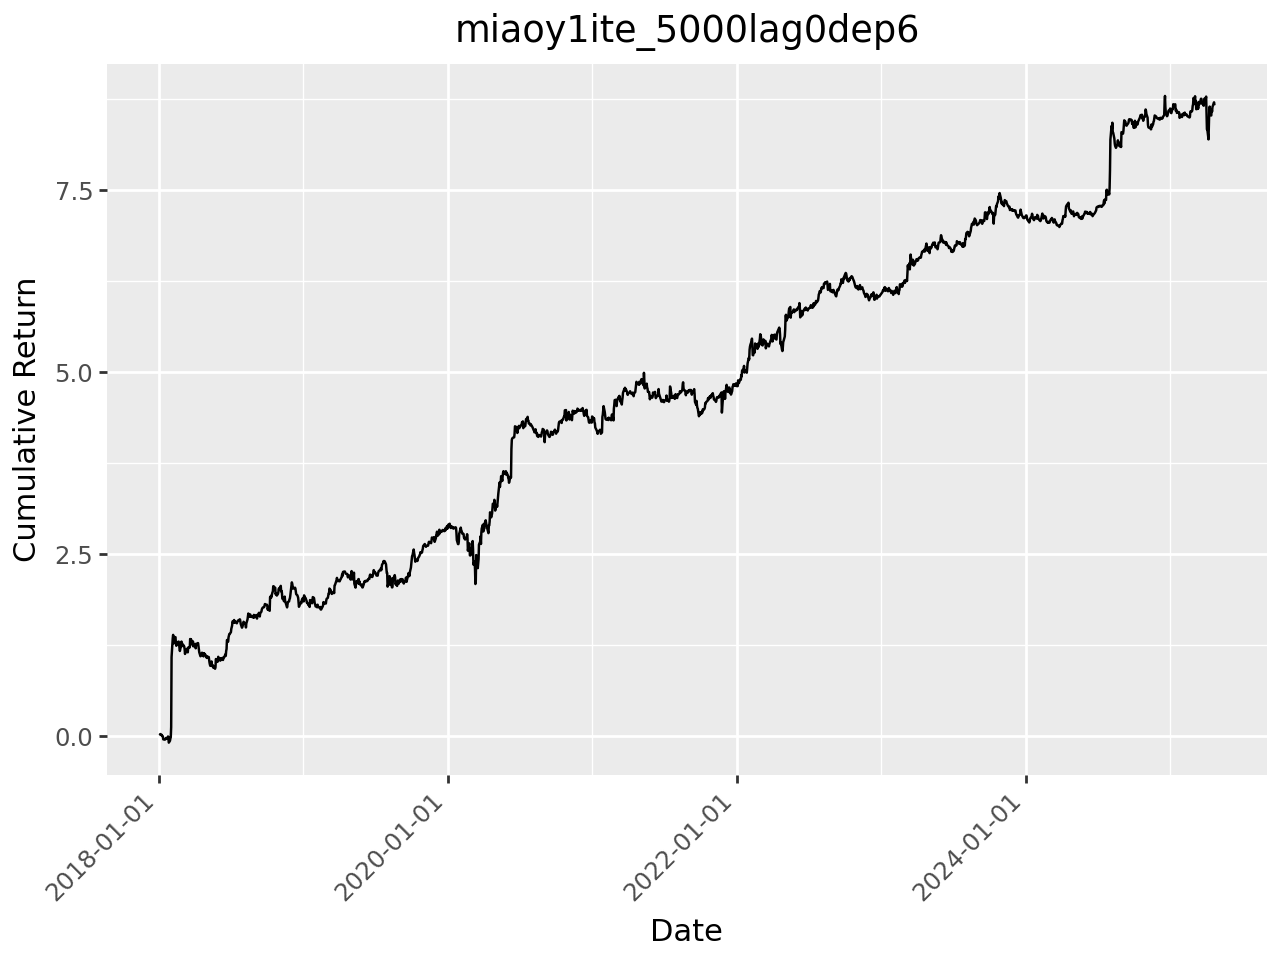

In [107]:
# train the default model
ite = 5000
dep = 6
model = cat.CatBoostRegressor(
    logging_level="Silent",
    iterations=ite,
    depth = dep,
    task_type='GPU'
)

train_pool = Pool(Xtrain1, Ytrain)
model.fit(train_pool)
# model.save_model(modelname)

# model = cat.CatBoostRegressor()
# model.load_model(modelname)

# go with the test set
# Xtest = test.iloc[:, x_indexs].values
Xtest1 = test.iloc[:, x_indexs]
Ytest = test[y_name].values
test_pool = Pool(Xtest1, Ytest)
Z = model.predict(test_pool)

pred_y = Z
bigtest = test.copy()  # just my naming convention to get the pred_y into the table
bigtest['pred_y'] = pred_y

modelname = 'miao' + 'y' + str(lookahead)+ 'ite_' + str(ite) + 'lag' + str(np.max(lags)) + 'dep' + str(dep) 

results = evaluate_and_plot(bigtest, modelname)
results.to_csv("miaoVIX.csv")

In [108]:

from random import randint

Xtrains = Xtrain1.values
Ytrains = train[y_name].values
# I add the s postfix to the variable names to indicate they are the full set to sample from 
obs, ncol = Xtrains.shape
n_boot = 20

df = pd.DataFrame()

for i in range(n_boot):
    print(f"Bootstrap iteration {i}")
    random_seed = randint(0, 99999)
    
    # Random sample with replacement
    samples = np.random.choice(obs, size=obs)
    Xtrain = Xtrains[samples, :]
    Ytrain = Ytrains[samples]
    
    # Random hyperparameters
    random_depth = randint(6, 10)
    random_iterations = randint(400, 2000)
    random_iterations = ite
    
    # Create model with randomized depth and iterations
    model = cat.CatBoostRegressor(
        logging_level="Silent",
        iterations=random_iterations,
        depth=random_depth,
        # random_seed=random_seed,
        task_type='GPU'
    )
    
    train_pool = Pool(Xtrain, Ytrain)
    val_pool = Pool(Xtrains, Ytrains)
    
    model.fit(
        train_pool,
        # early_stopping_rounds=30,
        use_best_model=True,
        eval_set=val_pool
    )
    
    Z = model.predict(test_pool)
    best_iteration = model.get_best_iteration()
    print(f"Best iteration: {best_iteration}, Depth: {random_depth}, Max Iterations: {random_iterations}")
    
    df[str(i)] = Z

# Final predictions
bigtest = test.copy().reset_index()
bigtest['pred_y'] = df.mean(axis=1, skipna=True)
modelname = 'miao' + 'y' + str(lookahead)+ 'ite_' + str(ite) + 'lag' + str(np.max(lags)) + 'nboot' + str(n_boot) 
results = evaluate_and_plot(bigtest, modelname)

Bootstrap iteration 0
Best iteration: 4999, Depth: 9, Max Iterations: 5000
Bootstrap iteration 1


KeyboardInterrupt: 

Bootstrap iteration 0
Best iteration: 99, Depth: 9, Max Iterations: 100
Bootstrap iteration 1
Best iteration: 99, Depth: 8, Max Iterations: 100
Bootstrap iteration 2
Best iteration: 99, Depth: 9, Max Iterations: 100
Bootstrap iteration 3
Best iteration: 99, Depth: 10, Max Iterations: 100
Bootstrap iteration 4
Best iteration: 99, Depth: 6, Max Iterations: 100
Bootstrap iteration 5
Best iteration: 99, Depth: 8, Max Iterations: 100
Bootstrap iteration 6
Best iteration: 99, Depth: 9, Max Iterations: 100
Bootstrap iteration 7
Best iteration: 99, Depth: 9, Max Iterations: 100
Bootstrap iteration 8
Best iteration: 99, Depth: 7, Max Iterations: 100
Bootstrap iteration 9
Best iteration: 99, Depth: 8, Max Iterations: 100
Bootstrap iteration 10
Best iteration: 99, Depth: 6, Max Iterations: 100
Bootstrap iteration 11
Best iteration: 99, Depth: 6, Max Iterations: 100
Bootstrap iteration 12
Best iteration: 99, Depth: 8, Max Iterations: 100
Bootstrap iteration 13
Best iteration: 99, Depth: 8, Max Ite

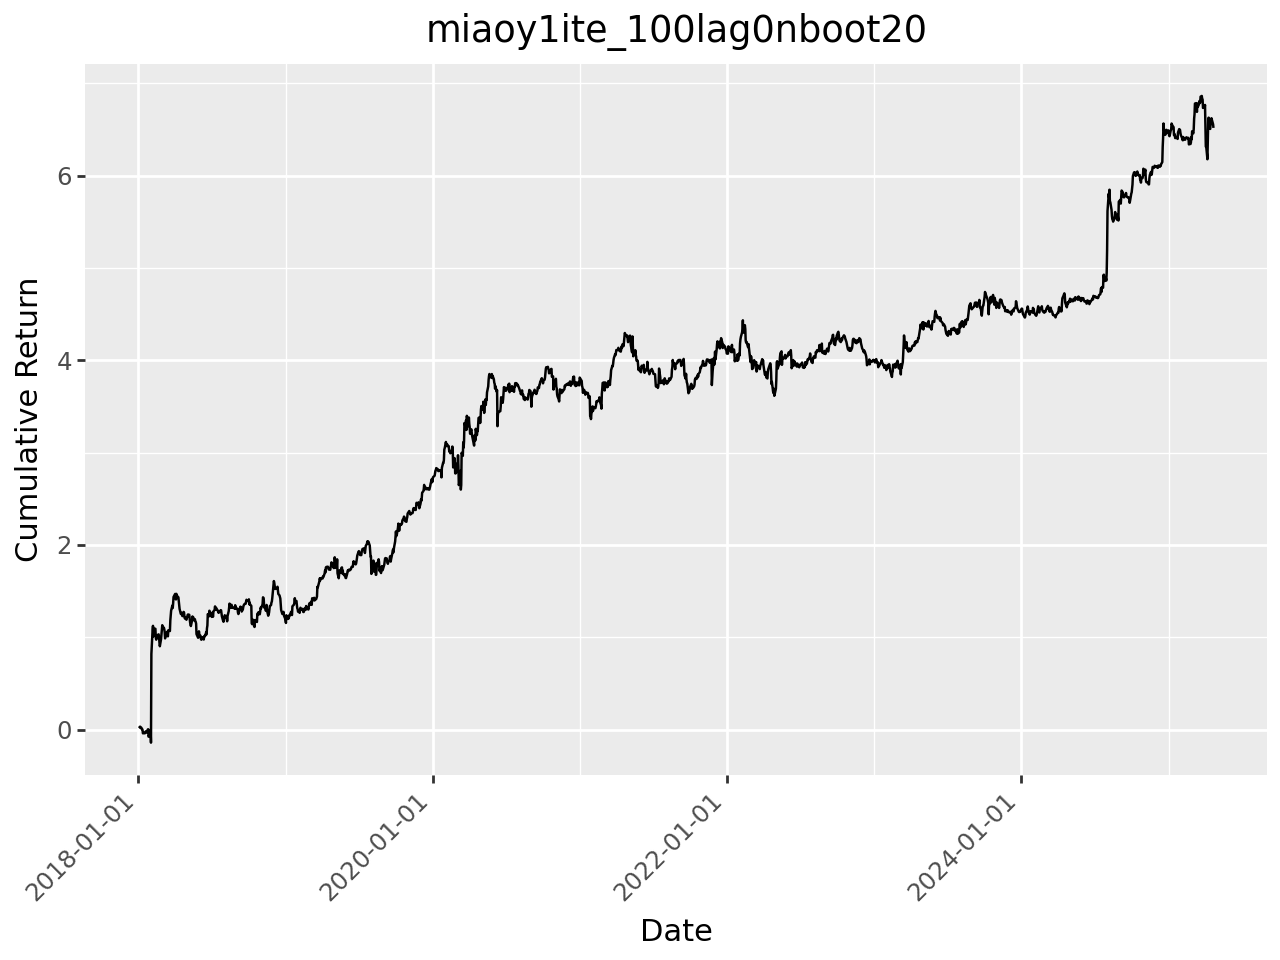

In [ ]:
from random import randint

Xtrains = Xtrain1.values
Ytrains = train[y_name].values
# I add the s postfix to the variable names to indicate they are the full set to sample from 
obs, ncol = Xtrains.shape
n_boot = 20

df = pd.DataFrame()

for i in range(n_boot):
    print(f"Bootstrap iteration {i}")
    random_seed = randint(0, 99999)
    
    # Random sample with replacement
    Xtrain = Xtrains
    Ytrain = Ytrains
    weights = np.random.uniform(1.0, 2.0, size=obs)  # random weight per point
    
    # Random hyperparameters
    random_depth = randint(6, 10)
    random_iterations = randint(400, 2000)
    random_iterations = ite
    
    # Create model with randomized depth and iterations
    model = cat.CatBoostRegressor(
        logging_level="Silent",
        iterations=random_iterations,
        depth=random_depth,
        random_seed=random_seed,
        task_type='GPU'
    )
    
    train_pool = Pool(Xtrain, Ytrain, weight=weights)
    val_pool = Pool(Xtrains, Ytrains)
    
    model.fit(
        train_pool,
        # early_stopping_rounds=30,
        use_best_model=True,
        eval_set=val_pool
    )
    
    Z = model.predict(test_pool)
    best_iteration = model.get_best_iteration()
    print(f"Best iteration: {best_iteration}, Depth: {random_depth}, Max Iterations: {random_iterations}")
    
    df[str(i)] = Z

# Final predictions
bigtest = test.copy().reset_index()
bigtest['pred_y'] = df.mean(axis=1, skipna=True)
modelname = 'miao' + 'y' + str(lookahead)+ 'ite_' + str(ite) + 'lag' + str(np.max(lags)) + ' Wnboot' + str(n_boot) 
results = evaluate_and_plot(bigtest, modelname)

Bootstrap iteration 0
Best iteration: 456, Depth: 7, Iterations: 457, Loss: RMSE
Bootstrap iteration 1
Best iteration: 1851, Depth: 8, Iterations: 1854, Loss: Huber:delta=0.0658
Bootstrap iteration 2
Best iteration: 449, Depth: 4, Iterations: 450, Loss: RMSE
Bootstrap iteration 3
Best iteration: 1984, Depth: 5, Iterations: 1987, Loss: RMSE
Bootstrap iteration 4
Best iteration: 1446, Depth: 10, Iterations: 1448, Loss: Huber:delta=0.0322
Bootstrap iteration 5
Best iteration: 764, Depth: 10, Iterations: 765, Loss: RMSE
Bootstrap iteration 6
Best iteration: 920, Depth: 6, Iterations: 921, Loss: Huber:delta=0.023
Bootstrap iteration 7
Best iteration: 1595, Depth: 5, Iterations: 1596, Loss: Huber:delta=0.0278
Bootstrap iteration 8
Best iteration: 1254, Depth: 9, Iterations: 1255, Loss: RMSE
Bootstrap iteration 9
Best iteration: 1509, Depth: 7, Iterations: 1510, Loss: RMSE
Bootstrap iteration 10
Best iteration: 1937, Depth: 6, Iterations: 1938, Loss: RMSE
Bootstrap iteration 11
Best iteration

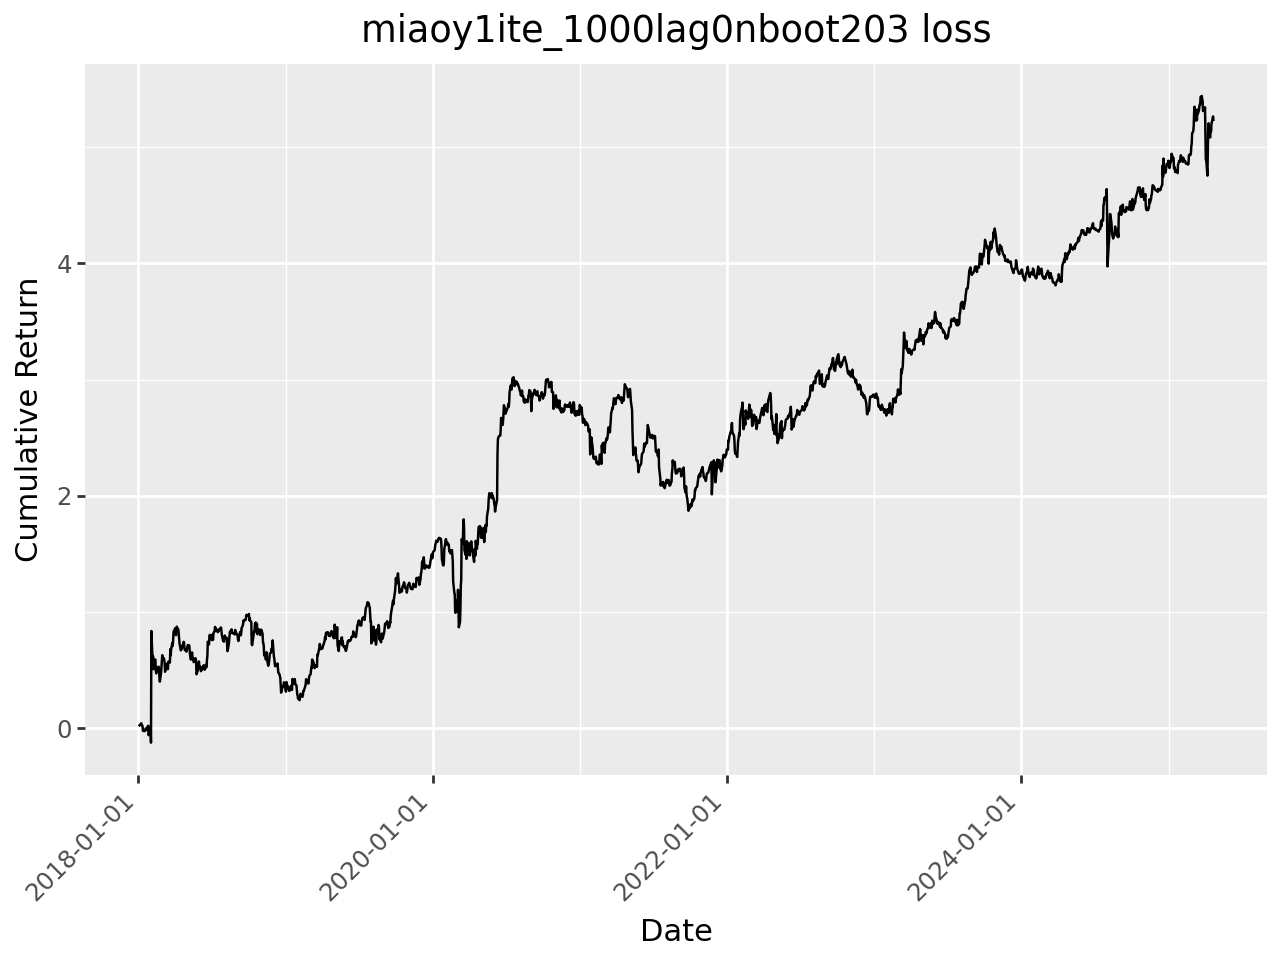

In [ ]:
from random import randint, uniform, choice

obs, ncol = Xtrains.shape
n_boot = 20

df = pd.DataFrame()

loss_log = []  # to keep track of which loss function was used

for i in range(n_boot):
    print(f"Bootstrap iteration {i}")
    
    samples = np.random.choice(obs, size=obs)
    Xtrain = Xtrains[samples, :]
    Ytrain = Ytrains[samples]

    # Random hyperparameters
    random_depth = randint(6, 10)
    random_iterations = randint(400, 2000)
    random_iterations = ite

    # Randomly choose among RMSE, MAE, Huber
    selected_loss = choice(['RMSE', 'MAE', 'Huber'])
    selected_loss = choice(['RMSE', 'Huber'])
    
    if selected_loss == 'Huber':
        random_delta = round(uniform(0.02, 0.1), 4)
        loss_function = f'Huber:delta={random_delta}'
    else:
        loss_function = selected_loss

    # Log loss function used
    loss_log.append(loss_function)

    # Define model
    model = cat.CatBoostRegressor(
        loss_function=loss_function,
        logging_level="Silent",
        iterations=random_iterations,
        depth=random_depth,
        task_type='GPU'
    )

    train_pool = Pool(Xtrain, Ytrain)
    val_pool = Pool(Xtrains, Ytrains)

    model.fit(
        train_pool,
        # early_stopping_rounds=30,
        use_best_model=True,
        eval_set=val_pool
    )

    Z = model.predict(test_pool)
    best_iteration = model.get_best_iteration()
    print(f"Best iteration: {best_iteration}, Depth: {random_depth}, Iterations: {random_iterations}, Loss: {loss_function}")

    df[str(i)] = Z

# Combine predictions
bigtest = test.copy().reset_index()
bigtest['pred_y'] = df.mean(axis=1, skipna=True)

# Show loss function usage summary
loss_summary = pd.Series(loss_log).value_counts()
print("\nLoss Function Usage Summary:")
print(loss_summary)

modelname = 'miao' + 'y' + str(lookahead)+ 'ite_' + str(ite) + 'lag' + str(np.max(lags)) + 'nboot' + str(n_boot) + ' 2 loss' 
results = evaluate_and_plot(bigtest, modelname)


In [ ]:
# create a list to save all the pred_y and concat them together
pred_y_list = []
ite = 5000
dep = 6

for y in np.arange(2018,2025):
    time1 = (str(y)+'-01-01')
    time2 = (str(y+1)+'-01-01')

    train = MLdata[MLdata.Date<time1]
    test = MLdata[(MLdata.Date>=time1) & (MLdata.Date<time2)]
    
    Ytrain = train[y_name].values
    Xtrain1 = train.iloc[:, x_indexs]

    # train the default model
    
    model = cat.CatBoostRegressor(
        logging_level="Silent",
        iterations=ite,
        depth = dep,
        task_type='GPU'
    )

    train_pool = Pool(Xtrain1, Ytrain)
    model.fit(train_pool)
    modelname = 'miao' + 'y' + str(lookahead)+ 'Y_'+str(y)+'ite_' + str(ite) + 'lag' + str(np.max(lags))
    # model.save_model(modelname)

    # model = cat.CatBoostRegressor()
    # model.load_model(modelname)

    # go with the test set
    # Xtest = test.iloc[:, x_indexs].values
    Xtest1 = test.iloc[:, x_indexs]
    Ytest = test[y_name].values
    test_pool = Pool(Xtest1, Ytest)
    Z = model.predict(test_pool)

    pred_y = Z
    bigtest = test.copy() # just my naming convention to get the pred_y into the table
    bigtest['pred_y'] = pred_y
    pred_y_list.append(bigtest)

bigtest = pd.concat(pred_y_list)

results = evaluate_and_plot(bigtest, modelname)